# Equation Rendering

Equation Rendering notebook 

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

In [344]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import tensorflow as tf
import jellyfish

from IPython.display import display, Latex

from tensorflow.keras.preprocessing.image import smart_resize

from importlib import reload 
import resolve_symbols
import render_equations

In [345]:
reload(resolve_symbols) #debugging
reload(render_equations)
from resolve_symbols import resolve_symbols_on_img
from render_equations import render_equation

Load in class labels from class_names.txt 

In [35]:
with open('../class_names.txt', 'r') as f:
    lines = f.readlines()
class_labels = [label.split(' ')[-1][:-1] for label in lines]

Load in the model

In [36]:
efficientnet_model = tf.keras.models.load_model('../CNN_model/efficientnet_model.h5')

Some images to test the rendering on

In [37]:
full_eq_imgs = glob.glob('../img_data/full_equations/*png')

Now let's write a function to actually make a prediction with the efficientnet model

In [342]:
def make_predictions(symbol_list, extend_list):

    pred_list = []
    pred_symbol_list, pred_idx_list = [], []
    for i, symbol in enumerate(symbol_list):

        rgb_im = np.zeros((symbol.shape[0], symbol.shape[1], 3))
        for j in range(3):
            rgb_im[:,:,j] = symbol.astype('uint8')
        resize_img = smart_resize(rgb_im, (100,100))
        resize_img = np.expand_dims(resize_img, axis=0)
        prediction = efficientnet_model.predict(resize_img, verbose=0)
    
        pred_dic = {k[6:]:v for v,k in sorted(zip(prediction[0], class_labels))[-4:]}
        y_classes = prediction.argmax(axis=-1)
        pred_idx_list.append(y_classes)
        label = class_labels[y_classes[0]][6:]
        
        #check if a symbol extends over multiple adjacent symbols
        #if it's not a square root, check if the square root is predicted at a lower probability
        #if so, just use that
        if extend_list[i] >  1 and label != '\\sqrt':
            if '\\sqrt' in pred_dic.keys(): 
                label = '\\sqrt'
        
            
        pred_symbol_list.append(label)
        pred_list.append(pred_dic)
    return pred_symbol_list

9: example of log correction going right
46: example of script level correction working <br>
50: stack + superscript + merging almost doing well <br>
130: simple test for sub/superscript <br>
140: merging x example at the end <br>
160: sin and cos in a fraction <br>
180 and 360: root extension test <br>
250: logs going wrong (and a little right) <br>
256: fractions with factorials doing well 

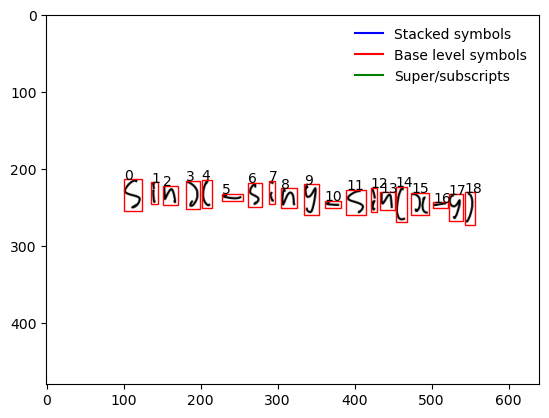

In [39]:
img_idx = 190
symbs, levels, stack, script_levels, extend_list, ax = resolve_symbols_on_img(full_eq_imgs[img_idx])

pred_symbol_list = make_predictions(symbs, extend_list)
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)

In [40]:
display(Latex(eqstr))

<IPython.core.display.Latex object>

In [41]:
eqstr

'$ \\sin ) ( - \\sin y - \\sin ( x - y )$'

### Evaluating the performance of the full pipeline

Now that the full pipeline is working, we want to know how well it does at actually predicting the equation label.
In order to gauge this, we will use the 'damerau-levenshtein distance', which measures how many symbols in two strings are different or need to be transposed

First let's retrieve the images we want to predict on

In [337]:
full_eq_imgs_eval = []
eq_dir = '../img_data/full_equations/'
for i in range(1000):
    full_eq_imgs_eval.append(eq_dir + 'full_eq_' + str(i) + '.png')

And load in the corresponding equation labels

In [338]:
#equation labels
with open(eq_dir + 'eq_labels.txt') as f:
    full_labels = f.readlines()
full_labels = [label[:-2] for label in full_labels]

In [339]:
comp_l = ['\\sum', '\\lim']
lim_labels = [label for label in full_labels if comp_l[0] in label or comp_l[1] in label]
trig_l = ['\\cos', '\\tan', '\\sin']
trig_labels = [label for label in full_labels if (trig_l[0] in label or trig_l[1] in label or trig_l[2] in label) and label not in lim_labels]


In order to make sure my equation strings and the labels look as similar as possible, I 'reprocess' the equation labels. One example of why this is necessary is that in the equation labels, if a single symbol is in a super or subscript ('^' or '_'), the symbol will somtimes not have curly brackets around them. While in my equation rendering function, it will.

In [340]:
def reprocess_eq(input_eq):
    """
    Reprocess the equation label, so that the comparison with the predicted equation label can be made
    Because I'm using the demerau-levenshtein distance to compare the predicted and actual equation strings
    it's important that the two are formatted as similarly as possible
    Input:
        equation string, read in from eq_labels.txct
    Returns:
        reprocessed equation string
    """
    
    #remove all whitespace and math mode markings ($), and make sure brackets are always labeled the same way
    input_eq = input_eq.replace(' ','').replace('$', '').replace('\left(','(').replace('right)',')').replace('\)',')').replace('\(','(')
    
    #add curly brackets around superscripts and subscripts
    br_ct = 0
    idx_l = []
    
    #first count how many instances of ^ and _ NOT followed by a curly bracket there are
    ss_list = ['^', '_']
    for i,s in enumerate(input_eq[:-1]):
        if s in ss_list and input_eq[i+1] != '{':
            idx_l.append(i+1)
            br_ct += 1
        
    #then rewrite the string piece by piece, adding curly opening and closing brackets where necessary
    input_eq_n = ''
    p = 0
    at_end = False
    for i in range(br_ct):

        input_eq_n += input_eq[p:idx_l[i]] + '{' + input_eq[idx_l[i]] + '}'
        if idx_l[i] == len(input_eq) - 1:
            at_end = True
        if at_end == False:
            p = idx_l[i]+1
            
    if at_end == False:
        input_eq_n += input_eq[p:]
    return input_eq_n

Now let's go through the full pipeline, and calculate the levenshtein-damerau distance between the predicted and actual equation strings

In [346]:
lvs_n, lvs_c, lvs_t = [],[],[]
for a in range(1000):
    if a%50==0:print(a)
    symbs, levels, stack, script_levels, extend_list = resolve_symbols_on_img(full_eq_imgs_eval[a], plot=False)
    pred_symbol_list = make_predictions(symbs, extend_list)
    eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
    
    predicted_eq = eqstr.replace(' ','').replace('$', '')
    actual_eq = reprocess_eq(full_labels[a])

    dl_dist = jellyfish.damerau_levenshtein_distance(predicted_eq, actual_eq)/len(actual_eq)
    if full_labels[a] in lim_labels:
        lvs_c.append(dl_dist)
    elif full_labels[a] in trig_labels:
        lvs_t.append(dl_dist)
    else:
        lvs_n.append(dl_dist)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [347]:
lvs_a = np.array(lvs_n + lvs_c + lvs_t)

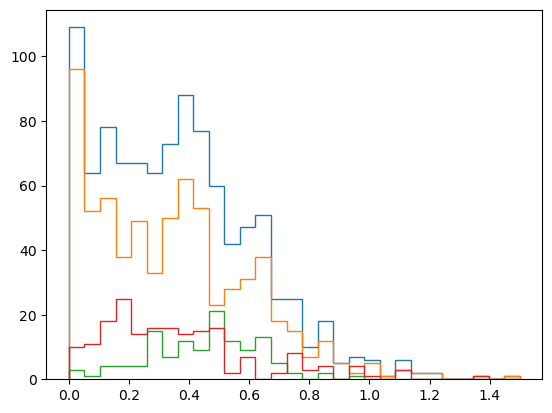

In [348]:
lbins = np.linspace(0, 1.5, 30)
plt.hist(lvs_a, bins=lbins, histtype='step')
plt.hist(lvs_n, bins=lbins, histtype='step')
plt.hist(lvs_c, bins=lbins, histtype='step')
plt.hist(lvs_t, bins=lbins, histtype='step')

plt.show()

In [349]:
def print_dist_info(input_dists):
    print('-' * 30)
    i_a = np.array(input_dists)
    p_0 = len(i_a[i_a == 0])/len(i_a)
    p_10 = len(i_a[i_a < 0.1])/len(i_a)
    p_25 = len(i_a[i_a < 0.25])/len(i_a)
    p_50 = len(i_a[i_a < 0.5])/len(i_a)

    print('perfect predictions:', p_0)
    print('normalized dist <0.1', p_10)   
    print('normalized dist <0.25', p_25)
    print('normalized dist <0.5', p_50)
    return

In [350]:
dists_l = [lvs_a, lvs_n, lvs_t, lvs_c]
for d in dists_l:
    print_dist_info(d)

------------------------------
perfect predictions: 0.088
normalized dist <0.1 0.154
normalized dist <0.25 0.366
normalized dist <0.5 0.72
------------------------------
perfect predictions: 0.11403508771929824
normalized dist <0.1 0.1915204678362573
normalized dist <0.25 0.4093567251461988
normalized dist <0.5 0.7309941520467836
------------------------------
perfect predictions: 0.036458333333333336
normalized dist <0.1 0.09895833333333333
normalized dist <0.25 0.3802083333333333
normalized dist <0.5 0.7708333333333334
------------------------------
perfect predictions: 0.024193548387096774
normalized dist <0.1 0.03225806451612903
normalized dist <0.25 0.10483870967741936
normalized dist <0.5 0.5806451612903226


In [101]:
idxs = np.where(lvs_a > 0.6)[0]

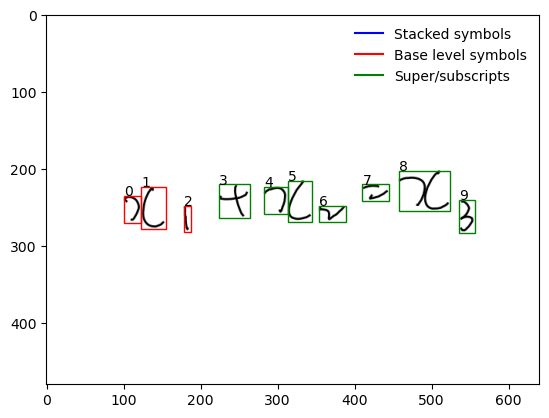

In [119]:
symbs, levels, stack, script_levels, extend_list, ax  = resolve_symbols_on_img(full_eq_imgs_eval[266], plot=True)
pred_symbol_list = make_predictions(symbs, extend_list)
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)

In [120]:
eqstr

'$ ) c 1^{ +  7  c  2^{ =  x} 3}$'

242


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

PREDICTED EQ: x1^{+x2^{=x3}}
ACTUAL EQ: x_{1}+x_{2}=x_{3}
0.6470588235294118
------------------------------
250


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

PREDICTED EQ: \log_{2}8=3
ACTUAL EQ: \log_{2}8=3
0.0
------------------------------
266


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

PREDICTED EQ: x1^{+7c2^{=x}3}
ACTUAL EQ: x_{1}+x_{2}=x_{3}
0.6470588235294118
------------------------------
272


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

PREDICTED EQ: 1_{y}==1\sin}2^{8+1}y!_{\lim3}g+h_{y}7au}4^{16}
ACTUAL EQ: \log_{2}8+\log_{3}9+\log_{4}16
1.2
------------------------------
274


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

PREDICTED EQ: nx^{d}
ACTUAL EQ: n\timesd
0.875
------------------------------


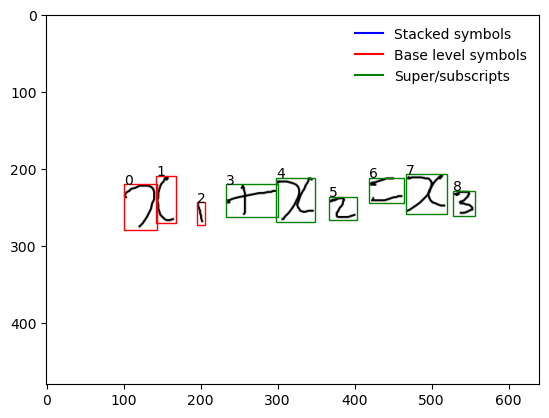

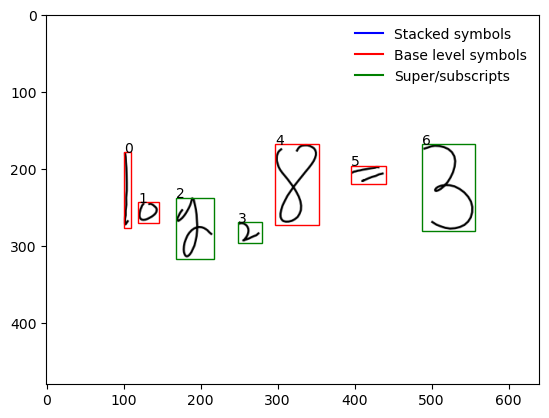

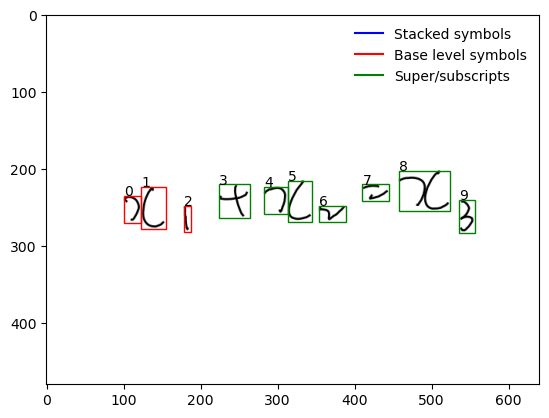

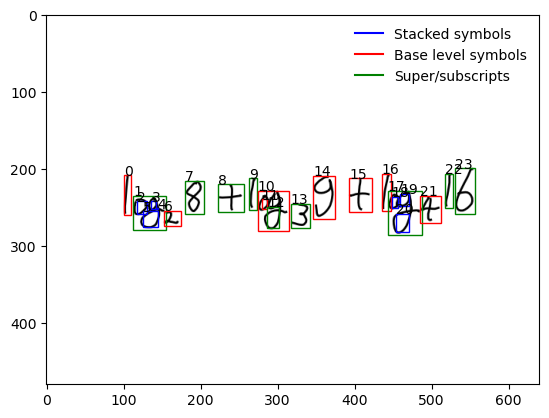

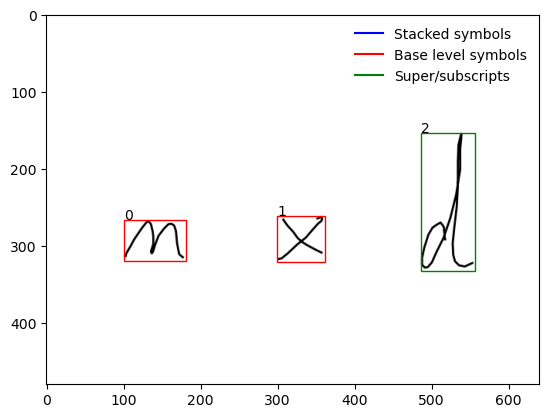

In [126]:
for a in idxs[25:30]:
    print(a)
    #if a%50==0:print(a)
    symbs, levels, stack, script_levels, extend_list, ax  = resolve_symbols_on_img(full_eq_imgs_eval[a], plot=True)
    pred_symbol_list = make_predictions(symbs, extend_list)
    eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
    predicted_eq = eqstr.replace(' ','').replace('$', '')
    actual_eq = reprocess_eq(full_labels[a])
    
    display(Latex(eqstr))
    display(Latex('$' + full_labels[a] + '$'))

    print('PREDICTED EQ:', predicted_eq)
    #print('unprocessed eq:', full_labels[a])
    print('ACTUAL EQ:', actual_eq)
    print(jellyfish.damerau_levenshtein_distance(predicted_eq, actual_eq)/len(actual_eq))
    
    print('-'*30)


In [476]:
pred_symbol_list

['x',
 '1',
 '-',
 'x',
 '2',
 '+',
 'y',
 '(',
 '-',
 'y',
 '3',
 '+',
 'z',
 '1',
 '-',
 'z',
 '2']

In [317]:
print(pred_symbol_list)

['\\gamma', '(', 'capital_X', ')', '=', '\\tan', 'n', '\\rightarrow', '\\infty', 'n', '!', 'n', 'k', '-', '\\times', '(', 'n', '+', '1', 'y']


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


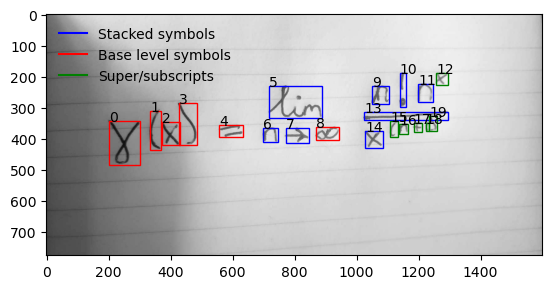

In [334]:
symbs, levels, stack, script_levels, extend_list, ax  = resolve_symbols_on_img('../math_martijn.jpeg', plot=True)
pred_symbol_list = make_predictions(symbs, extend_list)


In [332]:
img_file = '../img_data/train_symbols/label_\\lim/img_3.png'
img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)

make_predictions([img], [0])
#symb = o
#for symb in symbs[3:6]:
#    plt.figure()
#    plt.imshow(symb, cmap='gray')

0


['\\lim']

In [336]:
pred_symbol_list

['\\gamma',
 '(',
 'x',
 ')',
 '=',
 '\\tan',
 'n',
 '\\rightarrow',
 '\\infty',
 'n',
 '!',
 'n',
 'k',
 '-',
 '\\times',
 '(',
 'n',
 '+',
 '1',
 '1']

NameError: name 'patches' is not defined

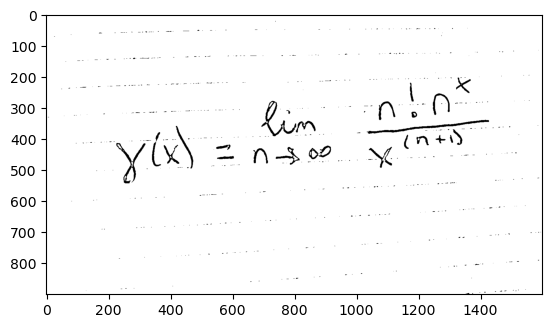

In [252]:
#find contours
import cv2
img_file = '../math_martijn2.jpeg'

img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
#ret,thresh=cv2.threshold(img,150, 255, cv2.THRESH_BINARY)
thresh  = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
blur = cv2.GaussianBlur(thresh,(9,9),0)
ret,thresh=cv2.threshold(blur,100, 255, cv2.THRESH_BINARY)


ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1])

fig, ax = plt.subplots()
ax.imshow(thresh, cmap='gray')

for i,c in enumerate(cnt[1:]):
    x1,y1,x2,y2= cv2.boundingRect(c)
    rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)



(array([3.95000e+02, 1.12400e+03, 1.80900e+03, 1.59000e+03, 1.83700e+03,
        1.97700e+03, 2.01900e+03, 1.75300e+03, 1.78400e+03, 1.75000e+03,
        2.59000e+03, 3.43700e+03, 4.85600e+03, 6.11500e+03, 7.25200e+03,
        8.85300e+03, 9.17200e+03, 1.08380e+04, 1.23290e+04, 1.77560e+04,
        1.94500e+04, 2.60030e+04, 3.23980e+04, 4.90790e+04, 6.18470e+04,
        8.56900e+04, 9.75960e+04, 1.40878e+05, 1.79397e+05, 6.48426e+05]),
 array([  1.        ,   9.46666667,  17.93333333,  26.4       ,
         34.86666667,  43.33333333,  51.8       ,  60.26666667,
         68.73333333,  77.2       ,  85.66666667,  94.13333333,
        102.6       , 111.06666667, 119.53333333, 128.        ,
        136.46666667, 144.93333333, 153.4       , 161.86666667,
        170.33333333, 178.8       , 187.26666667, 195.73333333,
        204.2       , 212.66666667, 221.13333333, 229.6       ,
        238.06666667, 246.53333333, 255.        ]),
 <BarContainer object of 30 artists>)

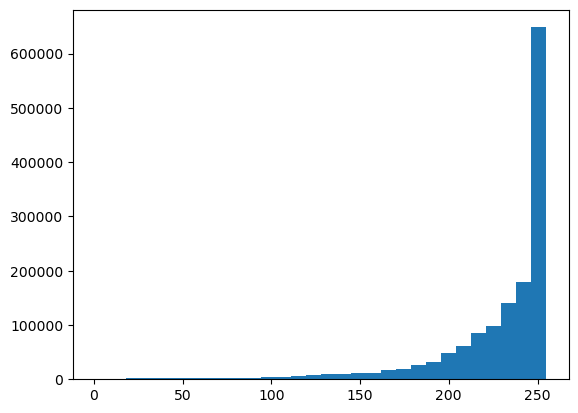

In [238]:
plt.hist(np.ravel(blur), bins=30)